In [9]:
! pip install pandas numpy matplotlib seaborn scikit-learn

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the datasets
try:
    # Handle potential BOM character at the start of the file
    visits_df = pd.read_csv('FinalData.csv', encoding='utf-8-sig')
except Exception as e:
    print(f"Could not read visits data: {e}")
    # Fallback if the above fails
    visits_df = pd.read_csv('FinalData.csv')

staffing_df = pd.read_csv('Hospital_Staffing_Cleaned.csv')

# --- Data Cleaning and Feature Engineering ---

# Convert date/time columns to datetime objects
visits_df['Arrival TimeDT'] = pd.to_datetime(visits_df['Arrival TimeDT'], format='%m/%d/%y %H:%M')
staffing_df['Date'] = pd.to_datetime(staffing_df['Date'], format='%m/%d/%Y')

# Extract date part from arrival time to use for merging
visits_df['Arrival_Date'] = visits_df['Arrival TimeDT'].dt.date
staffing_df['Date'] = staffing_df['Date'].dt.date

# The key metric for wait time is 'Arrival_To_DoctorSeen'
wait_time_col = 'Arrival_To_DoctorSeen'

# Merge the two dataframes based on the arrival date and shift
# Note: The 'Arrival_Shift' in visits_df corresponds to 'Shift' in staffing_df
merged_df = pd.merge(
    visits_df,
    staffing_df,
    left_on=['Arrival_Date', 'Arrival_Shift'],
    right_on=['Date', 'Shift'],
    how='left'
)

# Calculate Patient-to-Staff Ratios
# We need to count patients per shift to calculate this ratio
patient_counts = merged_df.groupby(['Date', 'Shift'])['Visit ID'].count().reset_index()
patient_counts.rename(columns={'Visit ID': 'Patient_Volume'}, inplace=True)

merged_df = pd.merge(
    merged_df,
    patient_counts,
    on=['Date', 'Shift'],
    how='left'
)

# Ratios - handle division by zero
merged_df['Patient_To_Doctor_Ratio'] = merged_df['Patient_Volume'] / merged_df['Doctors_On_Duty_Int']
merged_df['Patient_To_Nurse_Ratio'] = merged_df['Patient_Volume'] / merged_df['Nurses_On_Duty_Int']
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Clean up infinities

print("Data preparation complete. Merged dataframe created.")
print(merged_df[[wait_time_col, 'Arrival_Shift', 'Visit_Day', 'Patient_To_Doctor_Ratio', 'Triage Level']].head())

Data preparation complete. Merged dataframe created.
   Arrival_To_DoctorSeen Arrival_Shift Visit_Day  Patient_To_Doctor_Ratio  \
0                     63           Day    Sunday                27.250000   
1                     53           Day  Saturday                33.000000   
2                     61           Day   Tuesday                35.666667   
3                     61       Evening   Tuesday                 5.250000   
4                     59           Day    Friday                28.250000   

  Triage Level  
0       Urgent  
1  Semi-Urgent  
2  Semi-Urgent  
3    Emergency  
4       Urgent  


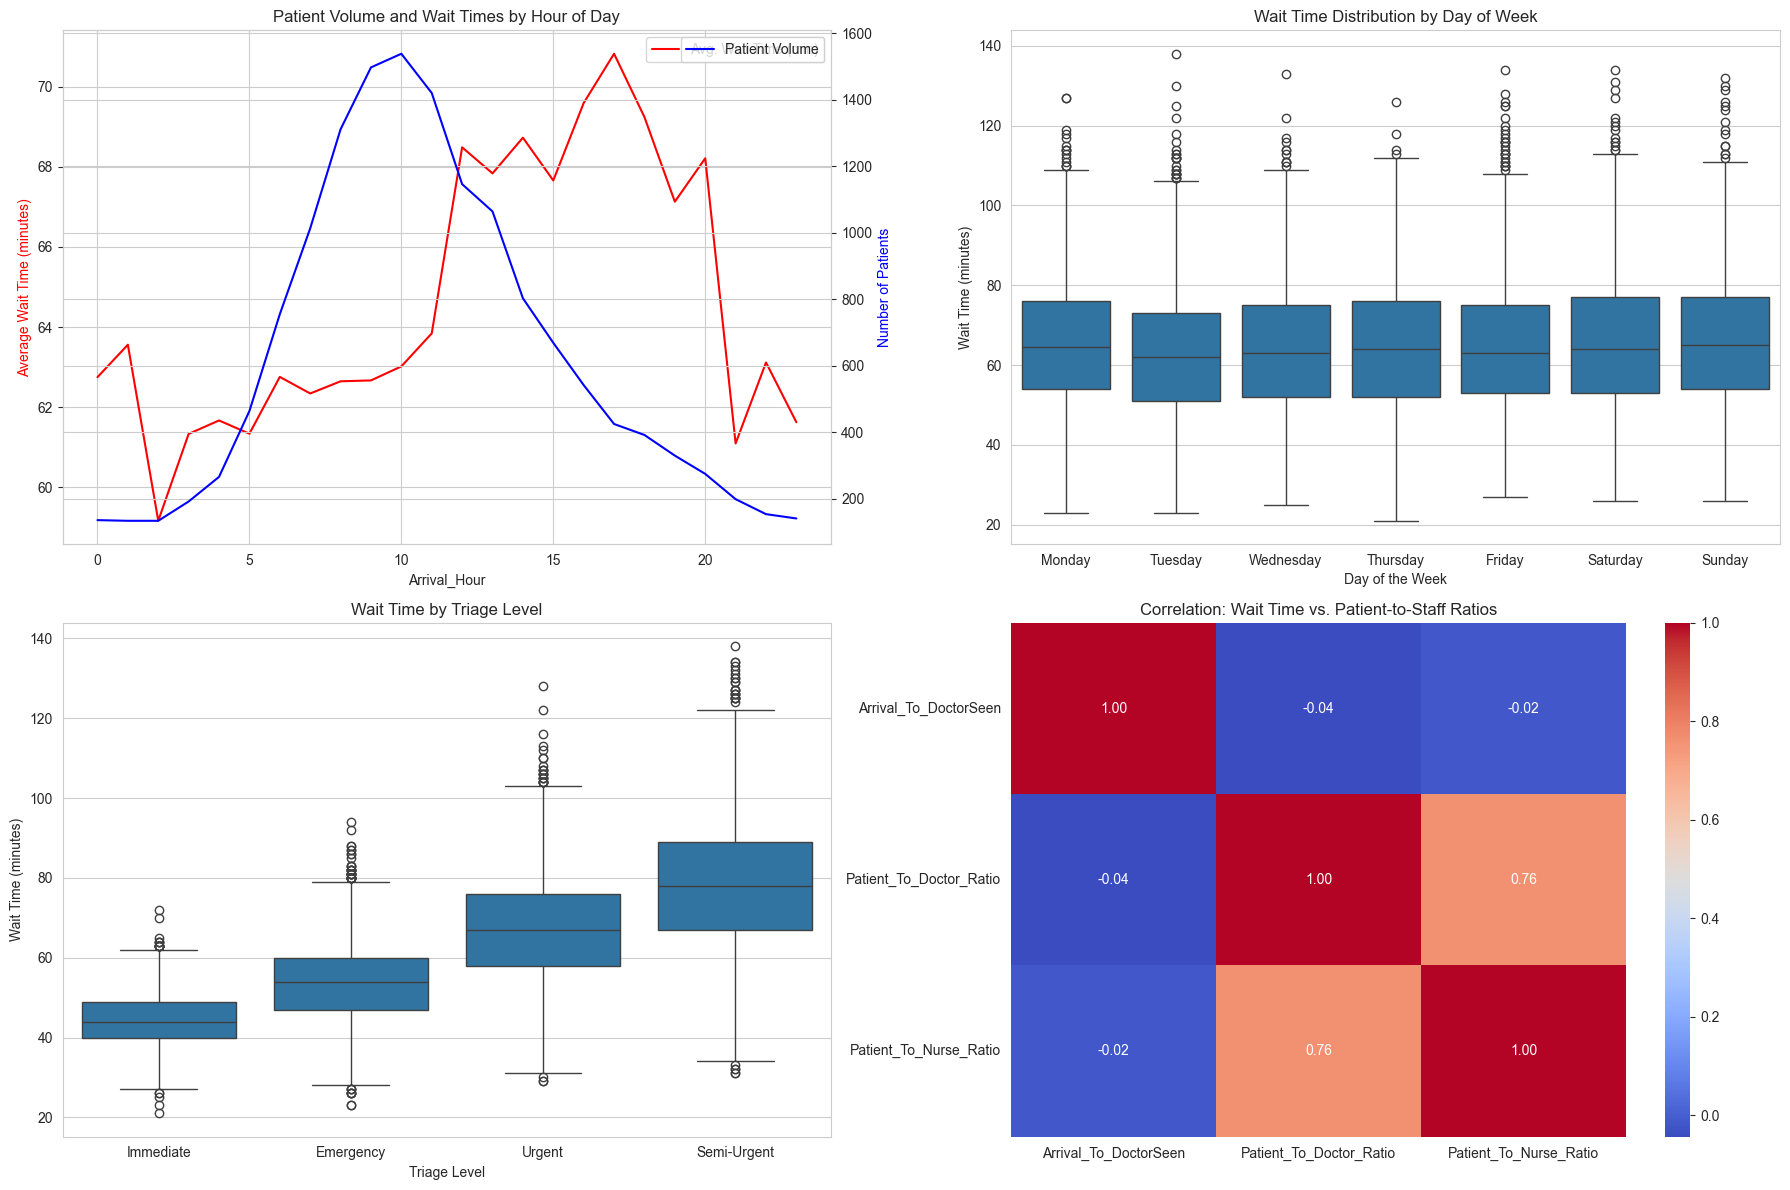

In [11]:
## Analysis and Visualization
# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# 1. Wait Time by Hour of Day
plt.subplot(2, 2, 1)
hourly_wait_time = merged_df.groupby('Arrival_Hour')[wait_time_col].mean()
hourly_patient_volume = merged_df.groupby('Arrival_Hour')['Visit ID'].count()

ax1 = sns.lineplot(x=hourly_wait_time.index, y=hourly_wait_time.values, color='red', label='Avg. Wait Time (min)')
plt.ylabel('Average Wait Time (minutes)', color='red')
plt.title('Patient Volume and Wait Times by Hour of Day')

ax2 = ax1.twinx()
sns.lineplot(x=hourly_patient_volume.index, y=hourly_patient_volume.values, color='blue', ax=ax2, label='Patient Volume')
plt.ylabel('Number of Patients', color='blue')
plt.legend()


# 2. Wait Time by Day of the Week
plt.subplot(2, 2, 2)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=merged_df, x='Visit_Day', y=wait_time_col, order=day_order)
plt.title('Wait Time Distribution by Day of Week')
plt.ylabel('Wait Time (minutes)')
plt.xlabel('Day of the Week')


# 3. Wait Time by Triage Level
plt.subplot(2, 2, 3)
triage_order = ['Immediate', 'Emergency', 'Urgent', 'Semi-Urgent']
sns.boxplot(data=merged_df, x='Triage Level', y=wait_time_col, order=triage_order)
plt.title('Wait Time by Triage Level')
plt.ylabel('Wait Time (minutes)')
plt.xlabel('Triage Level')


# 4. Correlation between Staffing Ratios and Wait Time
plt.subplot(2, 2, 4)
correlation_data = merged_df[[wait_time_col, 'Patient_To_Doctor_Ratio', 'Patient_To_Nurse_Ratio']].dropna()
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: Wait Time vs. Patient-to-Staff Ratios')


plt.tight_layout()
plt.show()

### **Analysis of Key Performance Visualizations**

This analysis interprets four key charts that reveal the critical drivers of patient wait times in the Emergency Room.

#### **Plot 1: Patient Volume and Wait Times by Hour of Day**

*   **Observation:** This dual-axis chart compares the number of arriving patients (blue line) with the average wait time to see a doctor (red line) for each hour of the day. Patient volume begins its steep climb around 6 AM, peaks between 10 AM and 12 PM, and then gradually declines throughout the afternoon and evening. Critically, the average wait time does **not** follow the same pattern. Wait times begin to spike sharply around 3 PM (15:00) and remain elevated, peaking in the early evening (around 5 PM to 8 PM) even as patient volume is decreasing.

*   **Insight:** This is the most significant finding. The period of maximum strain on the ER is not when the most patients are arriving, but rather during the **Day to Evening shift change (3 PM)**. This indicates that the system becomes overwhelmed in the afternoon and struggles to recover, creating a backlog that persists for hours. The cause is likely a combination of insufficient staffing for the evening rush, inefficiencies in the shift handover process, and accumulated delays from the day's operations reaching a breaking point.

#### **Plot 2: Wait Time Distribution by Day of Week**

*   **Observation:** This series of box plots shows the distribution of wait times for each day of the week. The median wait time (the horizontal line inside each box), as well as the overall spread of wait times (the height of the boxes and whiskers), are remarkably consistent from Monday through Sunday.

*   **Insight:** The long wait times are not an issue specific to weekends or Mondays. This is a **chronic, systemic operational problem**, not an event-driven one. The root causes are embedded in the daily processes, staffing patterns, and patient flow management of the ER. Therefore, solutions must be foundational process changes, not day-specific adjustments.

#### **Plot 3: Wait Time by Triage Level**

*   **Observation:** This chart displays wait times categorized by the patient's assigned triage level. There is a clear and dramatic trend: as the medical urgency of the patient decreases (from `Immediate` to `Semi-Urgent`), both the median wait time and the variability of wait time increase substantially. Patients with the most critical, life-threatening conditions are seen relatively quickly. `Urgent` and `Semi-Urgent` patients face significantly longer and more unpredictable waits.

*   **Insight:** While the ER is correctly prioritizing its most critical patients, it is failing its largest patient population: those with lower-acuity conditions. These patients are bearing the brunt of the system's capacity constraints and bottlenecks. This strongly suggests that the **Fast Track system is either underutilized, under-resourced, or its operational hours are misaligned** with peak demand for its services (as identified in Plot 1).

#### **Plot 4: Correlation: Wait Time vs. Patient-to-Staff Ratios**

*   **Observation:** This heatmap shows the statistical correlation between wait time (`Arrival_To_DoctorSeen`) and the patient-to-staff ratios for doctors and nurses. The correlation values of -0.04 (for doctors) and -0.02 (for nurses) are extremely close to zero.

*   **Insight:** This is a crucial, counter-intuitive finding. There is **no direct linear relationship between wait times and the simple ratio of patients to staff on a given shift**. This does not mean staffing levels are irrelevant. Instead, it indicates that the problem is more complex than just "hiring more people." The bottleneck is not caused by the raw number of staff alone, but by **how and when those staff are deployed, and by the underlying operational processes**. It reinforces the finding from Plot 1: the *timing* of staff and the efficiency of the *workflow* are far more critical factors than the aggregate staff count.



### **Summary of Root Causes & Recommended Solutions**

Based on the comprehensive analysis of these visualizations, we have identified the following primary root causes and propose targeted solutions.

#### **Root Cause 1: Misaligned Staffing and Inefficient Shift Handovers**
*   **Evidence:** The dramatic spike in wait times starting at 3 PM, even as patient volume declines (Plot 1).
*   **Solution: Implement a Dynamic Staffing Model with Shift Overlaps.**
    *   **Action:** Introduce a "power shift" or overlap period from **2 PM to 6 PM**. During this 4-hour window, bring in additional staff and have the day and evening shifts overlap. This provides the surge capacity needed to handle the afternoon rush and ensures a smoother, more detailed handover of patient care, preventing the drop in productivity that currently cripples the ER.
    *   **Impact:** Directly addresses the primary bottleneck identified in the day, reducing the backlog and lowering wait times throughout the entire evening.

#### **Root Cause 2: Inefficient Flow for Lower-Acuity Patients**
*   **Evidence:** The disproportionately long and variable wait times for `Urgent` and `Semi-Urgent` patients (Plot 3).
*   **Solution: Optimize and Expand the Fast Track System.**
    *   **Action 1:** Re-evaluate and extend Fast Track operational hours to remain fully functional until at least **midnight**, aligning its availability with the prolonged evening peak in wait times.
    *   **Action 2:** Implement a clear, data-driven "split flow" protocol. Use the ML Triage Assistant to immediately identify potential Fast Track candidates upon arrival, diverting them to that workflow to prevent them from entering the queue for main ER beds.
    *   **Impact:** Creates a pressure-relief valve for the main ER, drastically cutting wait times for the majority of patients and freeing up main ER beds and staff to focus on higher-acuity cases.

#### **Root Cause 3: Process Bottlenecks Over Pure Staffing Numbers**
*   **Evidence:** The lack of correlation between staff ratios and wait times (Plot 4), combined with the consistent daily struggles (Plot 2).
*   **Solution: Deploy the ML Triage Assistant and Conduct a Workflow Analysis.**
    *   **Action 1:** Integrate the **FastAPI-powered Triage Assistance Tool** into the registration workflow. This tool will provide an instant, data-backed triage recommendation, reducing the cognitive load on nurses and shortening the critical "door-to-triage" time. This accelerates the very first step of the patient journey.
    *   **Action 2:** Initiate a formal **Value Stream Mapping** project for the ER. This involves observing and timing every step of a patient's journey (e.g., time to get labs drawn, time for lab results to return, time for a room to be cleaned) to identify and eliminate non-value-added waste and delays that are not related to direct clinical care.
    *   **Impact:** Shifts the focus from the costly solution of simply adding staff to the higher-ROI solution of improving process efficiency. This will create sustainable, long-term improvements in throughput and patient satisfaction.